# OGGM run for an individual glacier with optimized A and MB gradient
- Compare ice thickness with default versus in situ MB gradients 
- plot the thickness difference for an individual glacier between OGGM linear gradient and a user defined mass balance gradient
- plot slope versus error
- plot flux versus error

In [1]:
##Ben Pelto June 2019

# Python imports
import os
import pandas as pd
import salem
from salem import *
import numpy as np
from scipy import stats 
import xarray as xr
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.workflow import execute_entity_task, gis_prepro_tasks, climate_tasks
from oggm.core.massbalance import ConstantMassBalance, MultipleFlowlineMassBalance
from oggm.core.climate import apparent_mb_from_linear_mb
from oggm.core.massbalance import LinearMassBalance

## Select the glacier by setting num to:

- 0 for Kokanee
- 1 for Haig
- 2 for Conrad
- 3 for W. Washmawapta (no DEM correction available)
- 4 for Illecillewaet (not supported in this version of the script due to shapefile reasons)
- 5 for Nordic (not supported in this version of the script due to shapefile reasons)
- 6 for Zillmer
- 7 Castle Creek

2020-06-04 14:06:39: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_pub/lib/python3.7/site-packages/oggm/params.cfg
2020-06-04 14:06:39: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-06-04 14:06:39: oggm.cfg: Multiprocessing: using all available processors (N=8)
2020-06-04 14:06:50: oggm.cfg: PARAMS['border'] changed from `20` to `10`.
2020-06-04 14:06:50: oggm.cfg: PARAMS['inversion_glen_a'] changed from `2.4e-24` to `9.78e-24`.
2020-06-04 14:06:50: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.
2020-06-04 14:06:51: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers


here


2020-06-04 14:06:54: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers


here


2020-06-04 14:06:56: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_pub/lib/python3.7/site-packages/oggm/core/gis.py:478: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2020-06-04 14:06:58: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2020-06-04 14:06:58: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2020-06-04 14:06:58: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2020-06-04 14:06:58: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2020-06-04 14:06:58: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2020-06-04 14:06:59: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
2020-06-04 14:06:59: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2020-06-04 14:07:00: oggm.workflow: Execute entity task catchment_width_correction on 1 glaciers
202

slope: 4.222811    intercept: -11041.927923   R-squared: 0.991692
default flowline thickness: 91.38
{'ela_h': 2540.317529563791, 'grad': 7.11}
slope default: 4.222811    intercept: -11041.927923   R-squared: 0.991692
slope: 6.148052    intercept: -15801.168528   R-squared: 0.960241


2020-06-04 14:07:03: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2020-06-04 14:07:04: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers
2020-06-04 14:07:04: oggm.workflow: Execute entity task distribute_thickness_per_altitude on 1 glaciers
2020-06-04 14:07:05: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


<xarray.DataArray 'distributed_thickness' ()>
array(76.72399, dtype=float32)
<xarray.DataArray 'distributed_thickness' ()>
array(70.77871, dtype=float32)
103.16
11.78
885
We now have 15.6 times less points, but the main features of the data remain unchanged:
885 885
oggm_thick 107.96 +/- 54.0
obs_mb_grad_thick 120.9 +/- 59.92
GPR depth (m): 138.64 +/- 56.4
mean observed depth point: 138.92
max observed depth gridded: 313.82
max observed depth point: 318.61
mean diff: 23.048371162255428
med. diff: 19.806787801106765
mean diff: 10.10872914469111
med. diff: 8.898364914603874


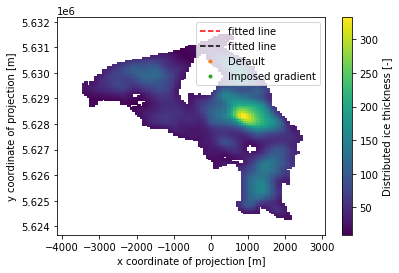

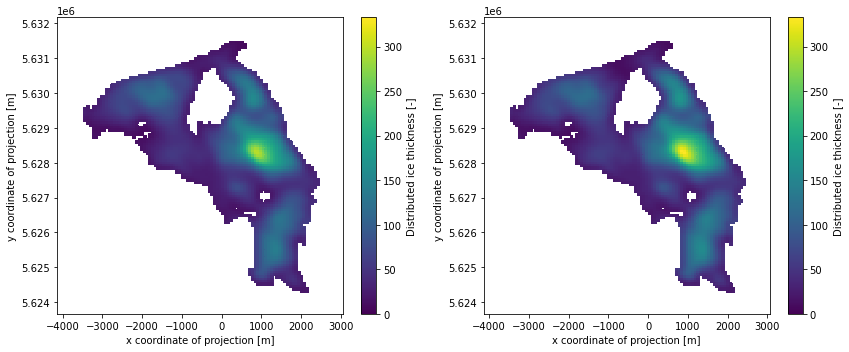

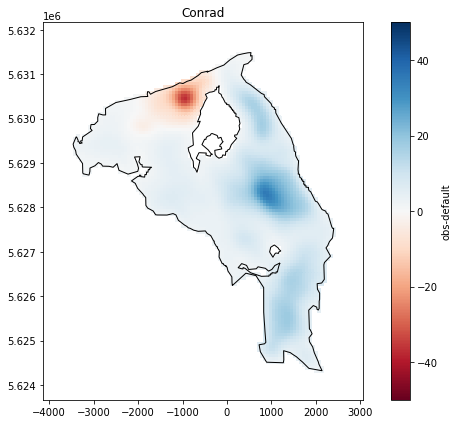

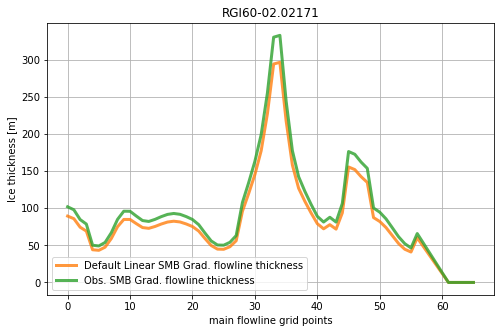

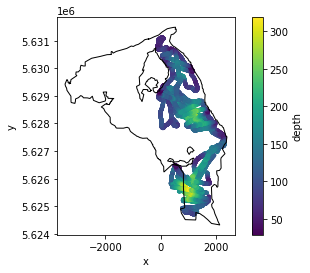

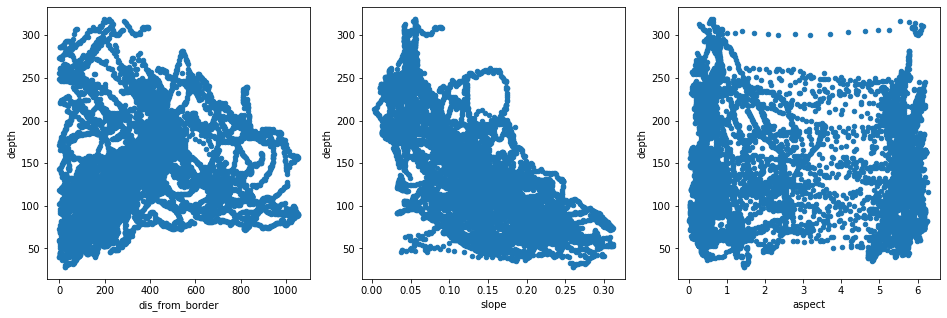

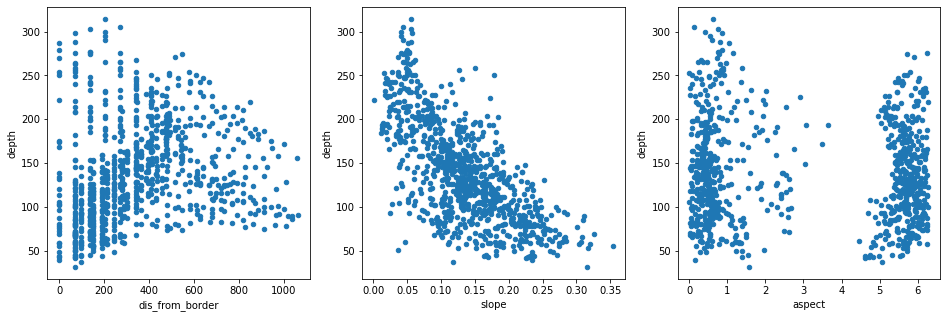

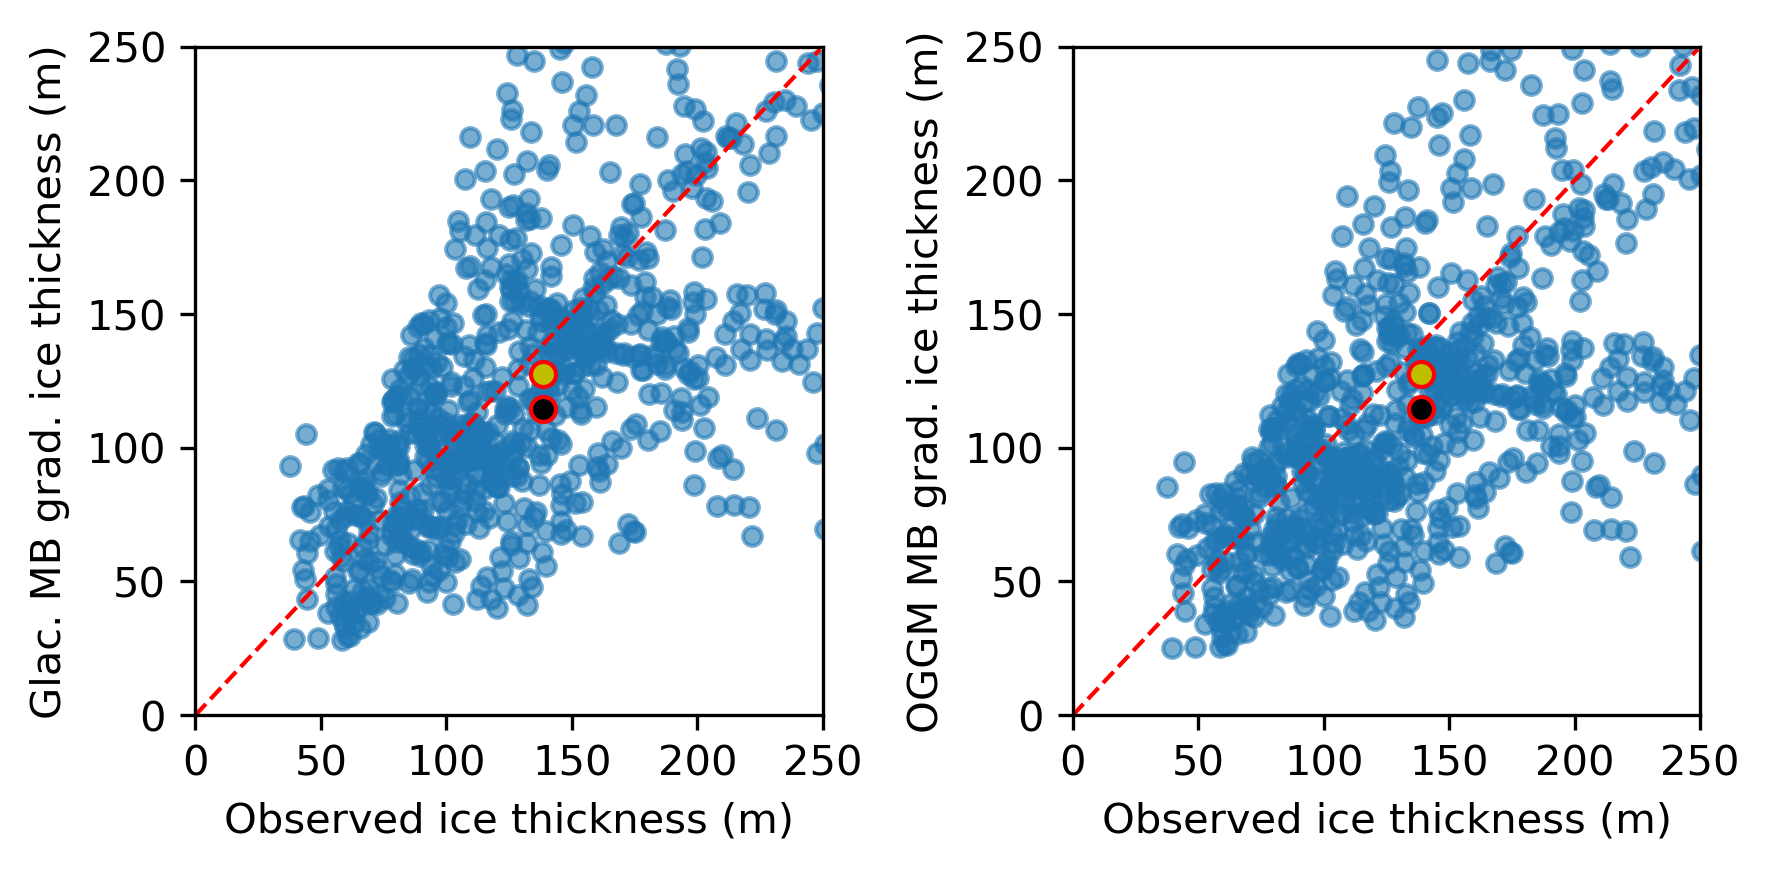

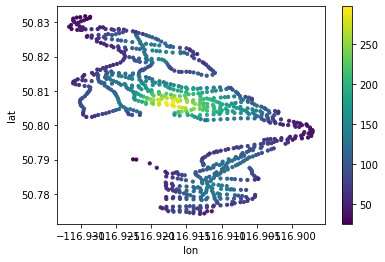

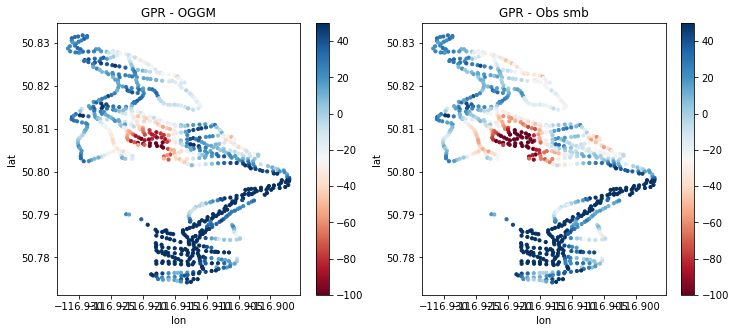

In [2]:
# for l in range(7):
num = 2 #num determines which gdir and gradient to use

#observational data points gradients
grad = [6.84, 9.8, 7.11, 9.8, 10.84, 6.01, 7.92, 7.19] # mm w.e. m-1 

fl_smooth = 1  # Gaussian smooth of the altitude along a flowline 
# sigma, in pixel coordinates (sigma=1 -> smooth around a -4:+4 window)

srtm = [-1.58, -6.95, -6.47, -5.71, -5.86, -6.11, 0.48, -6.00]
products_dir = '/home/pelto/Desktop/ice_thick/'
glacier = ['Kokanee', 'Haig', 'Conrad', 'Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer', 'Castle']

# list with the names Lidar data (according to the glacier names above)
dem = ['kokanee/20160913_kokanee_dem1_clip_slave.tif', 'haig/20150912_haig_dem_master_clip.tif', 'conrad/20160912_conrad_dem1_clip_slave.tif', 'not_assigned', 
       'illecillewaet/170917_illecillewaet_dem1_clip_slave.tif', 'nordic/20170927_nordic_dem1_clip_slave.tif', 'zillmer/160914_zillmer_dem2.tif']

#products_directory (where the graphs and some numbers are saved for later usage)
products= '/home/pelto/oggm_runs/products_opt/' + glacier[num] + '/'


WORKING_DIR = utils.get_temp_dir('MAEslope_thick' + glacier[num])
utils.mkdir(WORKING_DIR, reset=True)
cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = WORKING_DIR

# dx = 100 
# cfg.PARAMS['use_rgi_area'] = False
cfg.PARAMS['border'] = 10
cfg.PARAMS['flowline_height_smooth'] = fl_smooth
A = [7.65e-24, 2.99e-24,9.78e-24, 0.32e-24,5.37e-24,9.75e-24,8.7e-24]

cfg.PARAMS['inversion_glen_a'] = A[num]
cfg.PARAMS['smooth_window'] = 251.

#testing effect of larger grid cell size
# cfg.PARAMS['grid_dx_method'] = 'fixed'
# cfg.PARAMS['fixed_dx'] = dx
if glacier[num] == 'Washmawapta' or 'Nordic':
    cfg.PARAMS['use_intersects'] = False
else:
    cfg.PARAMS['use_intersects'] = True 

    # Get the RGI IDs for the run.
rgi_list = ['RGI60-02.00147', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.03411', 'RGI60-02.03688',
            'RGI60-02.04264', 'RGI60-02.07780', 'RGI60-02.08783']

rgidf = utils.get_rgi_glacier_entities([rgi_list[num]]) # Get a list of glacier outlines selected by RGI IDs

if glacier[num] == 'Washmawapta':
    print("No DEM for West Washmawapta")
else:
    custom_dem_path = '/home/pelto/Desktop/lidar_cbt_analysis/' + dem[num] 
    cfg.PATHS['dem_file'] = custom_dem_path
    rgidf['DEM_SOURCE'] = 'USER'

gdirs = workflow.init_glacier_directories(rgidf,reset=True, force=True)
print('here')
workflow.execute_entity_task(tasks.define_glacier_region, gdirs) # Initializes the list of Glacier Directories for this run
print('here')
workflow.gis_prepro_tasks(gdirs)        # runs all flowline preprocessing tasks
workflow.climate_tasks(gdirs)           # runs all climate related tasks
workflow.inversion_tasks(gdirs)         #runs all ice thickness inversion tasks

workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
gdir = gdirs[0]
oggm.core.gis.gridded_mb_attributes(gdir);
tasks.init_present_time_glacier(gdir) ##This updates the mode_flowlines file and creates a stand-alone numerical glacier ready to run.

# ds_default is the default inversion gridded data
ds_default = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_default.close()
gdir

mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True, mb_model_class=ConstantMassBalance)
z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

# grad_line = np.polyfit(mb_on_z,z,2)

slope, intercept, r_value, p_value, std_err = stats.linregress(z, mb_on_z)

# Print the standard MB gradient from OGGM default
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

#plot the OGGM default gradient for this glacier
plt.plot(z, intercept + slope*z, 'r--', label='fitted line');
plt.plot(z, mb_on_z, '.');
plt.title('Default OGGM Mass balance for this glacier');
plt.xlabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.ylabel('Altitude (m)');
plt.legend();

#calculate thickness along the model flowline
mfl=gdir.read_pickle('model_flowlines')
thickness_default = mfl[-1].surface_h - mfl[-1].bed_h
# thickness_default.mean()
default_thick = thickness_default[thickness_default>0].mean() #remove zeros from thickness calculation
print('default flowline thickness:', np.round(default_thick,2))

# Let's apply a linear MB instead
workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdir, mb_gradient=grad[num]);

params = gdir.read_pickle('linear_mb_params')
print(params)

#max_mb Cap the mass balance to a certain value (unit: [mm w.e. yr-1], we use 2000 mm w.e.
l_mb_mod = LinearMassBalance(params['ela_h'], grad=params['grad'], max_mb=2000.)
l_mb_on_z = l_mb_mod.get_annual_mb(z) * cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

slope, intercept, r_value, p_value, std_err = stats.linregress(z, mb_on_z)
print("slope default: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)
slope, intercept, r_value, p_value, std_err = stats.linregress(z, l_mb_on_z)
print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

plt.plot(z, intercept + slope*z, 'k--', label='fitted line');
plt.plot(z, mb_on_z, '.', label='Default');
plt.plot(z, l_mb_on_z, '.', label='Imposed gradient');
plt.ylabel('MB (kg m$^{-2}$ yr$^{-1}$)');
plt.xlabel('Altitude (m)');
plt.legend();

# Now let's recompute the inversion based on this new gradient
cfg.PARAMS['flowline_height_smooth'] = fl_smooth
workflow.inversion_tasks(gdirs)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
oggm.core.gis.gridded_mb_attributes(gdir);
tasks.init_present_time_glacier(gdir) ##trying to update the model flowline

#ds_new uses the in situ SMB gradient
ds_new = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
ds_new.close() 

ds_new.distributed_thickness.plot();

##side by side thickness...fine but hard to compare
vmax= ds_new.distributed_thickness.max()
vmin=0
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5));
ds_default.distributed_thickness.plot(ax=ax1, vmin=vmin, vmax=vmax); #default cmap is viridis
ds_new.distributed_thickness.plot(ax=ax2, vmin=vmin, vmax=vmax);
plt.tight_layout();

#plot thickness difference between the default SMB grad. inversion and in situ SMB grad. inversion
f, ax = plt.subplots(figsize=(8,6))
ds_new['obs-default'] = (ds_new.distributed_thickness - ds_default.distributed_thickness)
ds_new['obs-default'].plot(ax=ax, cmap='RdBu', vmin =-50, vmax=50); #'RdBu'
plt.ylabel('')
plt.xlabel('')
plt.title(glacier[num])
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');
plt.tight_layout()
# plt.savefig('/home/pelto/Desktop/ice_thick/' + glacier[num] + '_mb_grad_diff.png', dpi=600)

# "whole glacier thickness"
print(np.mean(ds_new.distributed_thickness))
print(ds_default.distributed_thickness.mean())

### Flowline glacier thickness:

mfl=gdir.read_pickle('model_flowlines')
thickness_MB = mfl[-1].surface_h - mfl[-1].bed_h
# thickness_MB.mean()
MB_thick = thickness_MB[thickness_MB>0].mean() #remove zeros
print(np.round(MB_thick , 2))

#compare flowline thickness in situ -- default
diff =  MB_thick - default_thick
print(np.round(diff, 2))

fig, ax = plt.subplots(figsize=[8,5])
ax.plot(thickness_default, 'C1', label='Default Linear SMB Grad. flowline thickness', linewidth=3, alpha=0.8)
ax.plot(thickness_MB, 'C2', label='Obs. SMB Grad. flowline thickness', linewidth=3, alpha=0.8)
ax.set_xlabel('main flowline grid points')
ax.set_ylabel('Ice thickness [m]')
ax.set_title(gdir.rgi_id)
ax.grid(True)
ax.legend();
# fig.savefig(products_dir + glacier[num] +'.tiff')

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# graphics.plot_raster(gdir, var_name='aspect', cmap='twilight', ax=ax1)
# graphics.plot_raster(gdir, var_name='oggm_mb_above_z', ax=ax2)

ds_new.to_netcdf('/home/pelto/oggm_runs/products_opt/' + glacier[num] + '/'+ glacier[num] +'_optimized_gridded_new.nc')

pd.set_option('display.max_columns', None)
utils.compile_glacier_statistics(gdirs, inversion_only=True)

# Import GPR observations

shapefile = ['2017/Kokanee_17_final_WGS84_clip.shp', 'Haig/Haig_gpr_all_WGS84.shp', 'conrad_GPR_ALL_final_WGS84.shp', 
             'west_wash_data.shp', '2018/illec_may18_final_WGS84_clipped.shp', '2016/Nordic_2016_GPR_final_WGS84.shp', 
             'zillmer_GPR_All_final_WGS84.shp']

##illecillewaet radar data causes failure if using RGI polygon due to data bounds, so I clipped the radar data for now

df = salem.read_shapefile('/home/pelto/GIS/GPR/Data/' + shapefile[num])

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]
# df['lon'] = df[4]
# df['lat'] = df[5]
df = df[['lon', 'lat', 'depth']]

# Convert the longitudes and latitudes to the glacier map projection:
xx, yy = salem.transform_proj(salem.wgs84, gdir.grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

#plot these data
geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
df.plot.scatter(x='x', y='y', c='depth',cmap='viridis', s=10, ax=ax); #cmap='Blues',
geom.plot(ax=ax, facecolor='none', edgecolor='k');

#     The measurement points of this dataset are very frequent and close to each other. There are plenty of them:

len(df)

# Here, we will keep them all and interpolate the variables of interest at a the point's location. 
# We use xarray for this:
vns = ['topo',
       'slope',
       'slope_factor',
       'aspect',
       'dis_from_border',
#        'catchment_area',
#        'lin_mb_above_z',
#        'lin_mb_above_z_on_catch',
       'oggm_mb_above_z',
       'oggm_mb_above_z_on_catch',
       ]

# Interpolate (bilinear)
for vn in vns:
    df[vn] = ds_new[vn].interp(x=('z', df.x), y=('z', df.y))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
df.plot.scatter(x='dis_from_border', y='depth', ax=ax1);
df.plot.scatter(x='slope', y='depth', ax=ax2);
df.plot.scatter(x='aspect', y='depth', ax=ax3);

### Method 2: aggregated per grid point

#     There are so many points that much of the information obtained by OGGM is interpolated. 
#     A way to deal with this is to aggregate all the measurement points per grid point and average them.
#     Let's do this: 


df_agg = df[['lon', 'lat', 'depth']].copy()
ii, jj = gdir.grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# We trick by creating an index of similar i's and j's
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

# Select
for vn in vns:
    df_agg[vn] = ds_new[vn].isel(x=('z', df_agg.i), y=('z', df_agg.j))

ds_crs =check_crs(ds_new)

print(len(df_agg))
points_diff = (len(df) / len(df_agg))
print('We now have',  np.round(points_diff, 1), 'times less points, but the main features of the data remain unchanged:')

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
df_agg.plot.scatter(x='dis_from_border', y='depth', ax=ax1);
df_agg.plot.scatter(x='slope', y='depth', ax=ax2);
df_agg.plot.scatter(x='aspect', y='depth', ax=ax3);

# Add the linear model data for comparison
df_agg['oggm_thick'] = ds_default.distributed_thickness.isel(x=('z', df_agg['i']), y=('z', df_agg['j']))
df_agg['obs_mb_grad_thick'] = ds_new.distributed_thickness.isel(x=('z', df_agg['i']), y=('z', df_agg['j']))

print(len(df_agg['depth']), len(df_agg['oggm_thick']))
print('oggm_thick', np.round(np.mean(df_agg['oggm_thick']) + srtm[num],2), '+/-' , np.round(np.std(df_agg['oggm_thick'])))
print('obs_mb_grad_thick', np.round(np.mean(df_agg['obs_mb_grad_thick'])+ srtm[num],2), '+/-' , np.round(np.std(df_agg['obs_mb_grad_thick']),2))
thickness_GPR = df_agg['depth']
GPR_thick = thickness_GPR[thickness_GPR>0].mean()
print('GPR depth (m):', np.round(GPR_thick, 2), '+/-' ,  np.round(np.std(df_agg['depth']),2))

print('mean observed depth point:', np.round(df['depth'].mean(),2))
print('max observed depth gridded:', np.round(thickness_GPR.max(),2))
print('max observed depth point:', df['depth'].max())

df_diff = df_agg['depth'] - (df_agg['oggm_thick']) #- 1.0)

print('mean diff:', np.mean(df_diff))
print('med. diff:', np.nanmedian(df_diff))

df_diff2 = df_agg['depth'] - (df_agg['obs_mb_grad_thick']) #- 1.0)

#df_diff
print('mean diff:', np.mean(df_diff2))
print('med. diff:', np.nanmedian(df_diff2))

df_agg['perc_diff_GPR_obs_smb'] = (np.abs(df_agg['depth'] - df_agg['oggm_thick'])) / ((df_agg['depth'] + df_agg['oggm_thick'])/2.)

val = 250

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), dpi=300);

df_agg.plot.scatter(x='depth', y='obs_mb_grad_thick', ax=ax1, alpha=0.6);
ax1.plot(np.arange(0, val), np.arange(0, val), 'r--', linewidth=1, zorder=1)
ax1.plot(np.mean(df_agg['depth']), np.mean(df_agg['obs_mb_grad_thick']), 'yo', markeredgecolor='r')
ax1.plot(np.mean(df_agg['depth']), np.mean(df_agg['oggm_thick']), 'ko', markeredgecolor='r')#, alpha=.85)
ax1.set_xlabel('Observed ice thickness (m)')  #, fontsize=12)
ax1.set_ylabel('Glac. MB grad. ice thickness (m)') # , fontsize=12)
ax1.set_xlim([0, val]);
ax1.set_ylim([0, val]);

df_agg.plot.scatter(x='depth', y='oggm_thick', ax=ax2, alpha=0.6);
ax2.plot(np.arange(0, val), np.arange(0, val), 'r--', linewidth=1, zorder=1)
ax2.set_xlabel('Observed ice thickness (m)') #, fontsize=12)
ax2.plot(np.mean(df_agg['depth']), np.mean(df_agg['oggm_thick']), 'ko', markeredgecolor='r')#, alpha=.85)
ax2.plot(np.mean(df_agg['depth']), np.mean(df_agg['obs_mb_grad_thick']), 'yo', markeredgecolor='r')
ax2.set_xlim([0, val]);
ax2.set_ylim([0, val]);
ax2.set_ylabel('OGGM MB grad. ice thickness (m)') #, fontsize=12)

# plt.legend()
plt.tight_layout()
# plt.savefig(products_dir + glacier[num] + '_MB_grads_vs_gpr_ice_thick.png')

##need to correct for SRTM height change to asess performance

#plot these data
# geom = gdir.read_shapefile('outlines')
f, ax = plt.subplots()
# diff = df_agg['oggm_thick'] - df_agg['obs_mb_grad_thick']
df_agg.plot.scatter(x='lon', y='lat', c=df_agg['oggm_thick'], cmap='viridis', s=10, ax=ax); #cmap='Blues',
# geom.plot(ax=ax, facecolor='none', edgecolor='k');

#GPR depth less oggm default thickness
# geom = gdir.read_shapefile('outlines')
f, (ax,ax1) = plt.subplots(1,2, figsize=(12, 5))
df_agg['GPR-oggm'] = df_agg['depth'] - df_agg['oggm_thick']
df_agg.plot.scatter(x='lon', y='lat', c=df_agg['GPR-oggm'], cmap='RdBu', s=10, ax=ax, vmax=50, vmin=-100); #cmap='Blues',
ax.title.set_text('GPR - OGGM')
# geom.plot(ax=ax, facecolor='no
#GPR depth less OGGM SMB thickness

geom = gdir.read_shapefile('outlines')
df_agg['GPR-obs_smb'] = df_agg['depth'] - df_agg['obs_mb_grad_thick']
df_agg.plot.scatter(x='lon', y='lat', c=df_agg['GPR-obs_smb'], cmap='RdBu', s=10, vmax=50, vmin=-100, ax=ax1); #cmap='Blues',
ax1.title.set_text('GPR - Obs smb')
# geom.plot(ax=ax) #facecolor='no)

# df_agg.to_csv(products_dir + glacier[num] + '_MBgrad.csv', index=False)
df_agg.to_csv(products_dir + glacier[num] + '_OPT.csv', index=False)
# ds_new.to_netcdf(products_dir + glacier[num] + '_MBgrad_gridded.nc')

df_agg['per_diff_GPR_obs_smb'] = (np.abs(df_agg['depth'] - df_agg['oggm_thick'])) / ((df_agg['depth'] + df_agg['oggm_thick'])/2.)
df_agg['ME'] = df_agg['depth'] - df_agg['obs_mb_grad_thick']
df_agg['MAE'] = np.abs(df_agg['depth'] - df_agg['obs_mb_grad_thick'])

all_agg_data=df_agg
# if num == 0:
#     all_agg_data=df_agg
# else:
#     all_agg_data=all_agg_data.append(df_agg)

## All Plots are displayed by scrolling through output above
- the above section may be split into individual cells to visualize the process

## Below I plot slope or flux versus error

-0.01612114254504405 0.6446215046288026


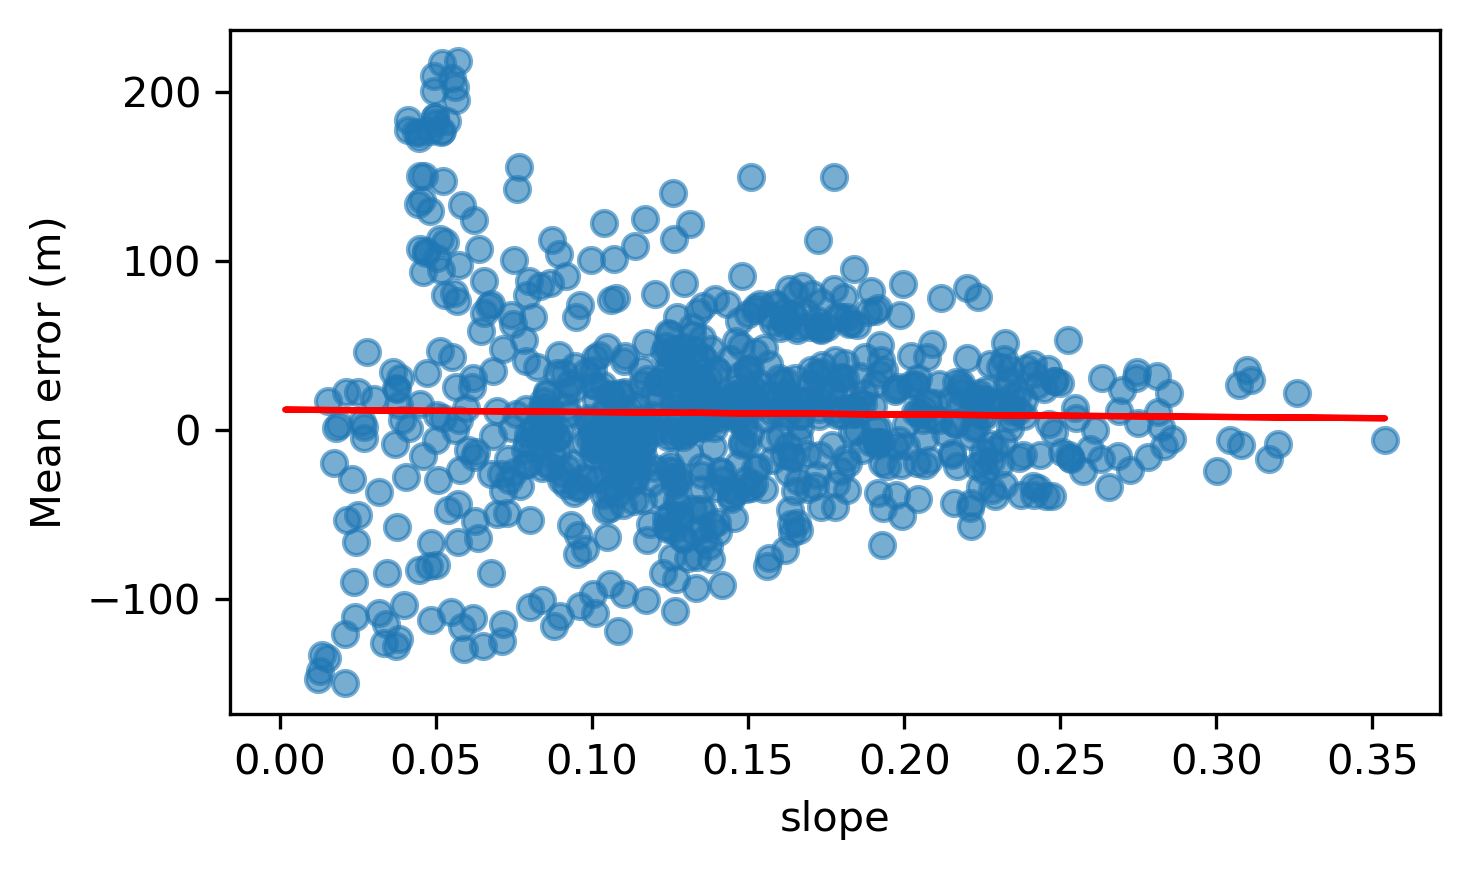

In [5]:
from scipy import stats


f, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300);

x= all_agg_data.slope
y= all_agg_data.ME

plt.scatter(x, y, alpha=0.6);
# ax1.plot(np.arange(0, val), np.arange(0, val), 'r--', linewidth=1, zorder=1)
# ax1.plot(np.mean(df_agg['depth']), np.mean(df_agg['obs_mb_grad_thick']), 'yo', markeredgecolor='r')
# ax1.plot(np.mean(df_agg['depth']), np.mean(df_agg['oggm_thick']), 'ko', markeredgecolor='r')#, alpha=.85)
ax.set_xlabel('slope')  #, fontsize=12)
ax.set_ylabel('Mean error (m)') # , fontsize=12)
# ax1.set_xlim([0, val]);
# ax1.set_ylim([0, val]);

mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
print(r_value,p_value)
plt.plot(x, intercept + slope*x, 'r', label='fitted line')

# plt.legend()
plt.tight_layout()
# plt.savefig(products_dir + glacier[num] + '_MB_grads_vs_gpr_ice_thick.png')

##need to correct for SRTM height change to asess performance

-0.3744189257362231 1.0151703723667056e-28


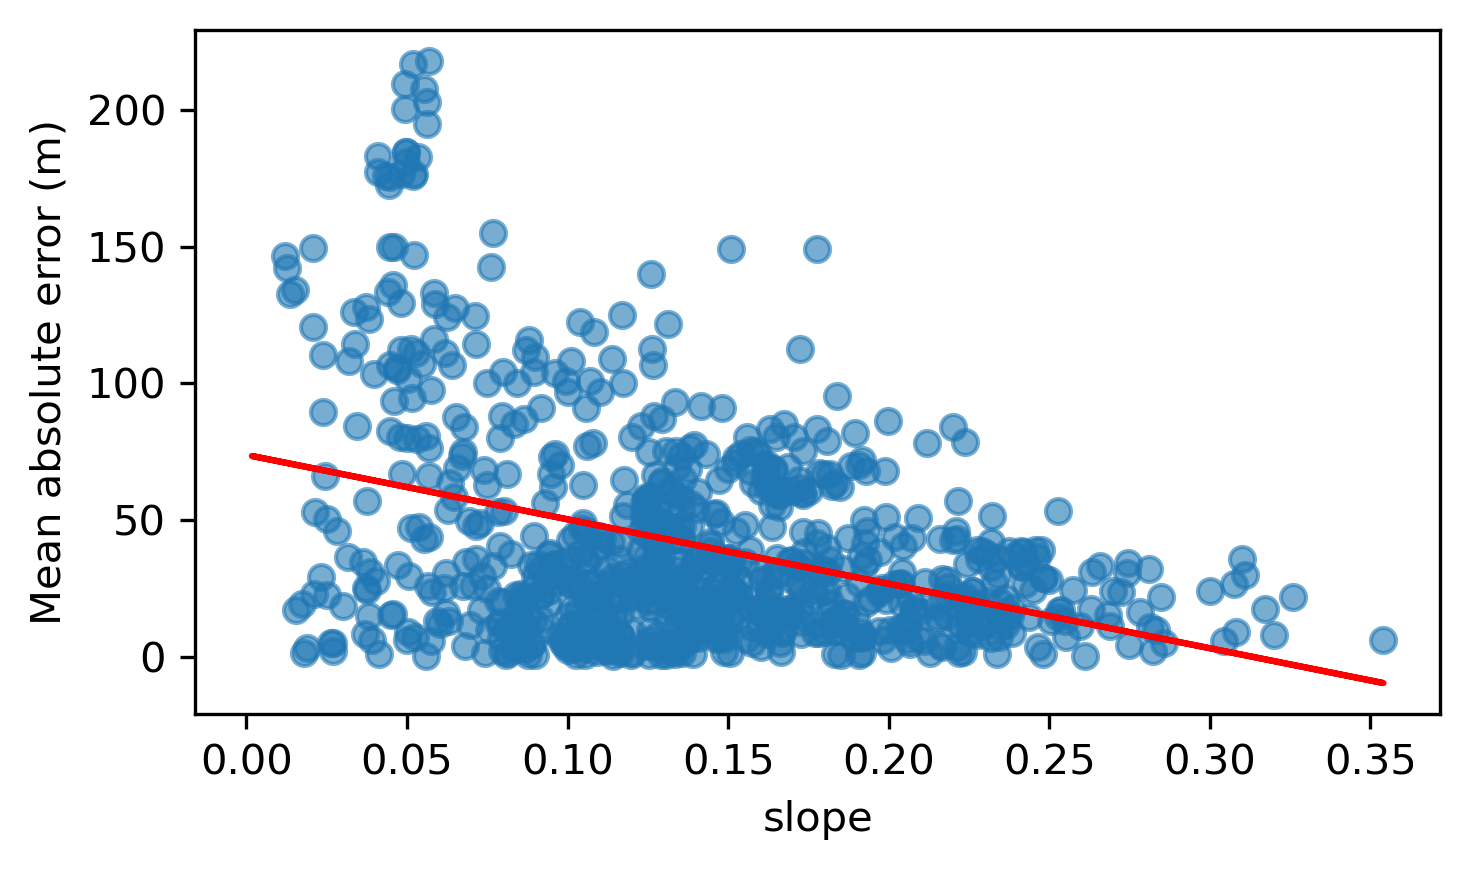

In [6]:
from scipy import stats


f, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300);

x= all_agg_data.slope
y= all_agg_data.MAE

plt.scatter(x, y, alpha=0.6);
# ax1.plot(np.arange(0, val), np.arange(0, val), 'r--', linewidth=1, zorder=1)
# ax1.plot(np.mean(df_agg['depth']), np.mean(df_agg['obs_mb_grad_thick']), 'yo', markeredgecolor='r')
# ax1.plot(np.mean(df_agg['depth']), np.mean(df_agg['oggm_thick']), 'ko', markeredgecolor='r')#, alpha=.85)
ax.set_xlabel('slope')  #, fontsize=12)
ax.set_ylabel('Mean absolute error (m)') # , fontsize=12)
# ax1.set_xlim([0, val]);
# ax1.set_ylim([0, val]);

mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
print(r_value,p_value)
plt.plot(x, intercept + slope*x, 'r', label='fitted line')

# plt.legend()
plt.tight_layout()
# plt.savefig(products_dir + glacier[num] + '_MAE_slope.png')

##need to correct for SRTM height change to asess performance

-0.07520336292428582 0.031194879629696137


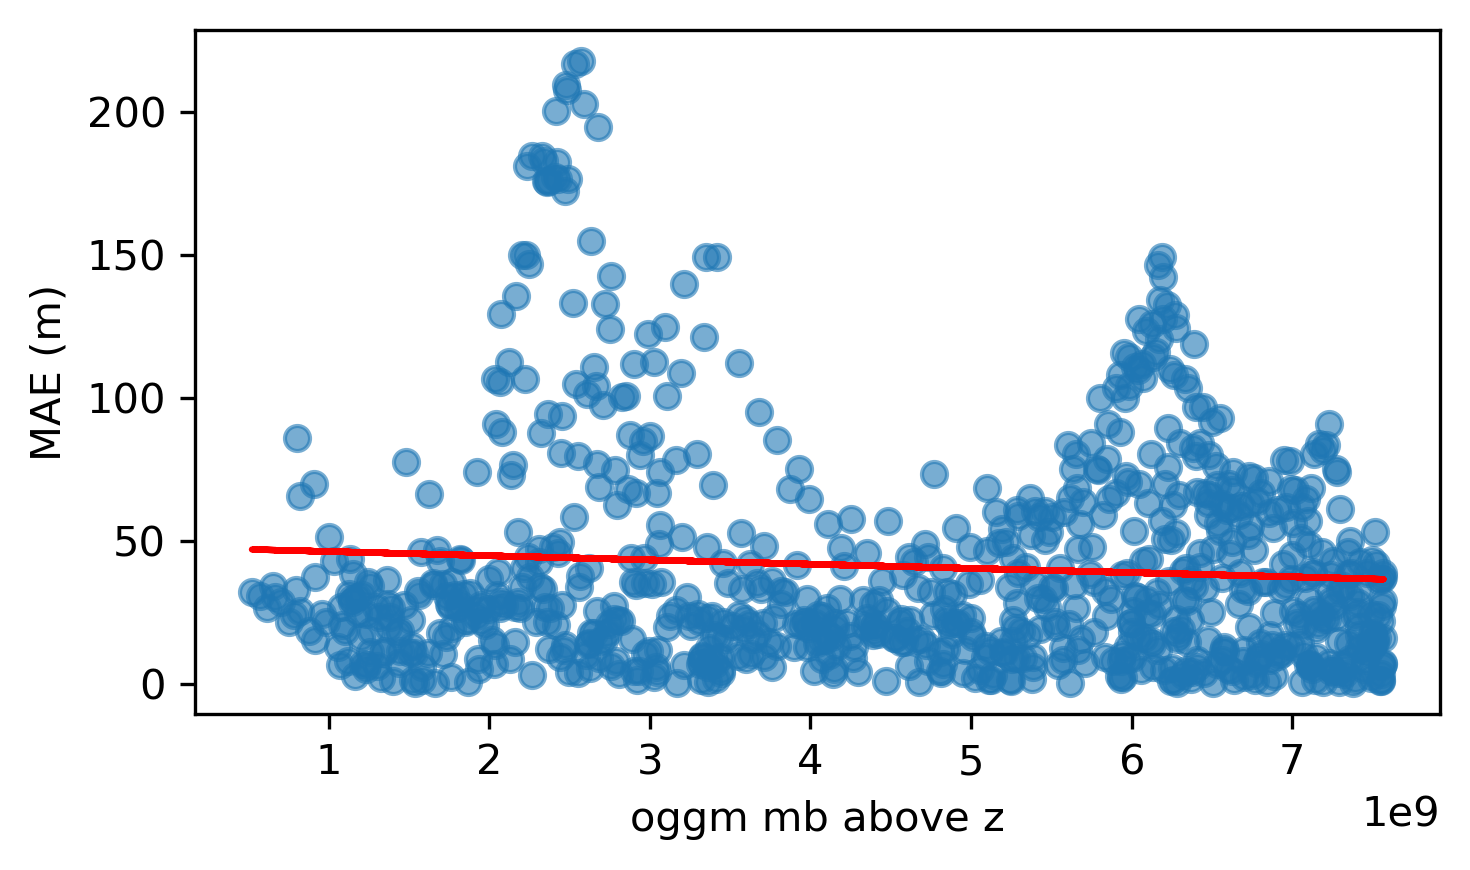

In [7]:
from scipy import stats


f, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300);

x= all_agg_data.oggm_mb_above_z
y= all_agg_data.MAE

# x[x<2e8]=np.nan

plt.scatter(x, y, alpha=0.6);
# ax1.plot(np.arange(0, val), np.arange(0, val), 'r--', linewidth=1, zorder=1)
# ax1.plot(np.mean(df_agg['depth']), np.mean(df_agg['obs_mb_grad_thick']), 'yo', markeredgecolor='r')
# ax1.plot(np.mean(df_agg['depth']), np.mean(df_agg['oggm_thick']), 'ko', markeredgecolor='r')#, alpha=.85)
ax.set_xlabel('oggm mb above z')  #, fontsize=12)
ax.set_ylabel('MAE (m)') # , fontsize=12)
# ax1.set_xlim([0, val]);
# ax1.set_ylim([0, val]);

mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
print(r_value,p_value)
plt.plot(x, intercept + slope*x, 'r', label='fitted line')

# plt.legend()
plt.tight_layout()
# plt.savefig(products_dir + glacier[num] + '_MB_grads_vs_gpr_ice_thick.png')

##need to correct for SRTM height change to asess performance